# **H-Store Analysis**

---



## **Importing** **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from scipy import stats
import statsmodels.api as sm
import xgboost as xgb
import joblib

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'

## **Loading Dataset**

In [ ]:
df = pd.read_csv('/content/train_sample copy.csv')
df.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,...,google + online,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,...,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Data Cleaning and Preprocessing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         20000 non-null  int64  
 1   channelGrouping                                    20000 non-null  object 
 2   date                                               20000 non-null  int64  
 3   fullVisitorId                                      20000 non-null  uint64 
 4   sessionId                                          20000 non-null  object 
 5   socialEngagementType                               20000 non-null  object 
 6   visitId                                            20000 non-null  int64  
 7   visitNumber                                        20000 non-null  int64  
 8   visitStartTime                                     20000 non-null  int64  
 9   device

In [ ]:
print (df.isnull().sum())

Unnamed: 0                                               0
channelGrouping                                          0
date                                                     0
fullVisitorId                                            0
sessionId                                                0
socialEngagementType                                     0
visitId                                                  0
visitNumber                                              0
visitStartTime                                           0
device.browser                                           0
device.browserVersion                                    0
device.browserSize                                       0
device.operatingSystem                                   0
device.operatingSystemVersion                            0
device.isMobile                                          0
device.mobileDeviceBranding                              0
device.mobileDeviceModel                                

In [ ]:
# Delete columns with "not provided in demo dataset"
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1 and df[col].iloc[0] == "not available in demo dataset"]
df = df.drop(columns=columns_to_drop)

In [ ]:
# Delete rows with "(not set)"
columns_to_check = ['geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country']
df = df[~df[columns_to_check].eq("(not set)").any(axis=1)]

# Delete insignificant columns with numerous blank rows
columns_to_drop = ['trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent', 'geoNetwork.region', 'geoNetwork.city', 'geoNetwork.metro']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
# Identifying numerical and categorical columns/features
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("Numerical Features:", numerical_features)
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features:", categorical_features)

Numerical Features: ['Unnamed: 0', 'date', 'fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime', 'totals.visits', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.page']
Categorical Features: ['channelGrouping', 'sessionId', 'socialEngagementType', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'trafficSource.campaign', 'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword', 'trafficSource.isTrueDirect', 'trafficSource.referralPath']


In [ ]:
# Replace NaNs in desired numerical columns with 0
numerical_cols_to_fill = ['totals.bounces', 'totals.newVisits', 'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.page']
df[numerical_cols_to_fill] = df[numerical_cols_to_fill].fillna(0)

# Replace NaNs in desired categorical columns with 'unknown' and 'False'
df['trafficSource.keyword'] = df['trafficSource.keyword'].fillna('unknown')
df['trafficSource.isTrueDirect'] = df['trafficSource.isTrueDirect'].fillna(False)
df['trafficSource.referralPath'] = df['trafficSource.referralPath'].fillna('unknown')

<ipython-input-10-730f475b785d>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['trafficSource.isTrueDirect'] = df['trafficSource.isTrueDirect'].fillna(False)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19975 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           19975 non-null  int64  
 1   channelGrouping                      19975 non-null  object 
 2   date                                 19975 non-null  int64  
 3   fullVisitorId                        19975 non-null  uint64 
 4   sessionId                            19975 non-null  object 
 5   socialEngagementType                 19975 non-null  object 
 6   visitId                              19975 non-null  int64  
 7   visitNumber                          19975 non-null  int64  
 8   visitStartTime                       19975 non-null  int64  
 9   device.browser                       19975 non-null  object 
 10  device.operatingSystem               19975 non-null  object 
 11  device.isMobile                  

In [ ]:
# Reset the index to make the date a regular column
df = df.reset_index()

# If the date column is now named 'index', rename it to 'date'
if 'index' in df.columns:
  df = df.drop(columns=['date'], errors='ignore')
  df = df.rename(columns={'index': 'date'})
# Convert to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# Proceed with calculating 'isWeekend'
df['isWeekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

In [ ]:
# Adjust data types for specified columns
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Convert specified columns to integers
int_cols = ['totals.bounces', 'fullVisitorId', 'totals.newVisits']
df[int_cols] = df[int_cols].astype(int)

# Convert 'visitStartTime' to datetime
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

df.set_index('date', inplace=True)

In [ ]:
df.head()

,Unnamed: 0,channelGrouping,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,isWeekend
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000000000,0,Organic Search,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,2016-09-02 15:33:05,Chrome,Windows,...,1,0.0,(not set),google,organic,(not provided),False,unknown,0.0,0
1970-01-01 00:00:00.000000001,1,Organic Search,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,2016-09-03 05:22:27,Firefox,Macintosh,...,1,0.0,(not set),google,organic,(not provided),False,unknown,0.0,0
1970-01-01 00:00:00.000000002,2,Organic Search,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,2016-09-03 01:16:26,Chrome,Windows,...,1,0.0,(not set),google,organic,(not provided),False,unknown,0.0,0
1970-01-01 00:00:00.000000003,3,Organic Search,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,2016-09-03 05:40:13,UC Browser,Linux,...,1,0.0,(not set),google,organic,google + online,False,unknown,0.0,0
1970-01-01 00:00:00.000000004,4,Organic Search,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,2016-09-02 13:23:20,Chrome,Android,...,0,0.0,(not set),google,organic,(not provided),True,unknown,0.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19975 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000019999
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Unnamed: 0                           19975 non-null  int64         
 1   channelGrouping                      19975 non-null  object        
 2   fullVisitorId                        19975 non-null  int64         
 3   sessionId                            19975 non-null  object        
 4   socialEngagementType                 19975 non-null  object        
 5   visitId                              19975 non-null  int64         
 6   visitNumber                          19975 non-null  int64         
 7   visitStartTime                       19975 non-null  datetime64[ns]
 8   device.browser                       19975 non-null  object        
 9   device.operatingSystem               1

## **Feature Engineering (I)**

In [ ]:
# Revenue per visit
df['revenuePerVisit'] = df['totals.transactionRevenue'] / df['totals.visits']
df['revenuePerVisit']

,revenuePerVisit
date,
1970-01-01 00:00:00.000000000,0.0
1970-01-01 00:00:00.000000001,0.0
1970-01-01 00:00:00.000000002,0.0
1970-01-01 00:00:00.000000003,0.0
1970-01-01 00:00:00.000000004,0.0
...,...
1970-01-01 00:00:00.000019995,0.0
1970-01-01 00:00:00.000019996,0.0
1970-01-01 00:00:00.000019997,0.0


In [ ]:
# Revenue per user
revenue_by_user = df.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
df = df.merge(revenue_by_user, on='fullVisitorId', how='left', suffixes=('', '_user'))
df['revenuePerUser'] = df['totals.transactionRevenue_user'] / df.groupby('fullVisitorId')['totals.visits'].transform('sum')
df['revenuePerUser']

,revenuePerUser
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
19970,0.0
19971,0.0
19972,0.0
19973,0.0


In [ ]:
# Revenue per continent
revenue_by_continent = df.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum()
df = df.merge(revenue_by_continent, on='geoNetwork.continent', how='left', suffixes=('', '_continent'))
df['revenuePerContinent'] = df['totals.transactionRevenue_continent'] / df.groupby('geoNetwork.continent')['totals.visits'].transform('sum')
df['revenuePerContinent']

,revenuePerContinent
0,4.279303e+04
1,0.000000e+00
2,2.066710e+04
3,4.279303e+04
4,2.066710e+04
...,...
19970,2.066710e+04
19971,3.120912e+06
19972,3.120912e+06
19973,4.279303e+04


In [ ]:
# Bounce rate
df['bounceRate'] = df['totals.bounces'] / df['totals.visits']
df['bounceRate']

,bounceRate
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19970,1.0
19971,1.0
19972,1.0
19973,1.0


In [ ]:
# New users rate
df['newUsersRate'] = df['totals.newVisits'] / df['totals.visits']
df['newUsersRate']

,newUsersRate
0,1.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
19970,1.0
19971,0.0
19972,1.0
19973,1.0


In [ ]:
# Pageviews per visit
df['pageviewsPerVisit'] = df['totals.pageviews'] / df['totals.visits']
df['pageviewsPerVisit'].fillna(0, inplace=True)
df['pageviewsPerVisit']

<ipython-input-21-d1eee104d823>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pageviewsPerVisit'].fillna(0, inplace=True)


,pageviewsPerVisit
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19970,1.0
19971,1.0
19972,1.0
19973,1.0


In [ ]:
# Weekday vs. Weekend
df['isWeekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
df['isWeekend']

KeyError: 'date'

In [ ]:
# Time of Day
df['timeOfDay'] = pd.cut(df['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)
df['timeOfDay']

,timeOfDay
0,Afternoon
1,Night
2,Night
3,Night
4,Afternoon
...,...
19970,Evening
19971,Afternoon
19972,Night
19973,Morning


In [ ]:
# Device Category
df['deviceCategory'] = df['device.deviceCategory']
df['deviceCategory']

,deviceCategory
0,desktop
1,desktop
2,desktop
3,desktop
4,mobile
...,...
19970,desktop
19971,desktop
19972,desktop
19973,desktop


In [ ]:
# Frequency of user visits
frequency = df.groupby('fullVisitorId')['visitStartTime'].count().reset_index()
frequency.columns = ['fullVisitorId', 'frequency']

# Merge frequency back into the main DataFrame
df = df.merge(frequency, on='fullVisitorId', how='left')

In [ ]:
df.describe()

,Unnamed: 0,fullVisitorId,visitId,visitNumber,visitStartTime,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,...,isWeekend,revenuePerVisit,totals.transactionRevenue_user,revenuePerUser,totals.transactionRevenue_continent,revenuePerContinent,bounceRate,newUsersRate,pageviewsPerVisit,frequency
count,19975.000000,1.997500e+04,1.997500e+04,19975.000000,19975,19975.0,19975.000000,19975.000000,19975.000000,19975.000000,...,19975.0,1.997500e+04,1.997500e+04,1.997500e+04,1.997500e+04,1.997500e+04,19975.000000,19975.000000,19975.000000,19975.000000
mean,10000.566708,3.213499e+18,1.484141e+09,2.271990,2017-01-11 13:17:18.346433024,1.0,4.637947,3.865031,0.524155,0.772416,...,0.0,1.610409e+06,2.496211e+06,1.610409e+06,1.636672e+10,1.610409e+06,0.524155,0.772416,3.865031,1.212165
min,0.000000,-9.221688e+18,1.470896e+09,1.000000,2016-08-11 07:00:13,1.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,1.000000
25%,5002.500000,9.002184e+17,1.472872e+09,1.000000,2016-09-03 03:10:22.500000,1.0,1.000000,1.000000,0.000000,1.000000,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,9.449000e+07,2.066710e+04,0.000000,1.000000,1.000000,1.000000
50%,10000.000000,3.666903e+18,1.485441e+09,1.000000,2017-01-26 14:24:37,1.0,1.000000,1.000000,1.000000,1.000000,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.187700e+10,3.120912e+06,1.000000,1.000000,1.000000,1.000000
75%,15000.500000,6.415894e+18,1.489355e+09,1.000000,2017-03-12 21:43:59,1.0,4.000000,4.000000,1.000000,1.000000,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.187700e+10,3.120912e+06,1.000000,1.000000,4.000000,1.000000
max,19999.000000,9.223212e+18,1.498288e+09,389.000000,2017-06-24 06:59:47,1.0,331.000000,197.000000,1.000000,1.000000,...,0.0,1.698580e+09,1.698580e+09,1.188550e+09,3.187700e+10,3.120912e+06,1.000000,1.000000,197.000000,10.000000
std,5773.615438,4.314531e+18,9.240682e+06,9.119127,NaN,0.0,9.835672,7.055524,0.499429,0.419283,...,0.0,2.757561e+07,3.535258e+07,2.423195e+07,1.586656e+10,1.545223e+06,0.499429,0.419283,7.055524,0.641387


## **Visualization**

## Geographical

### 1. Total Users by Continent

<ipython-input-94-cf5fee79bd39>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Continent', y='TotalUsers', data=continent_users, palette="viridis")


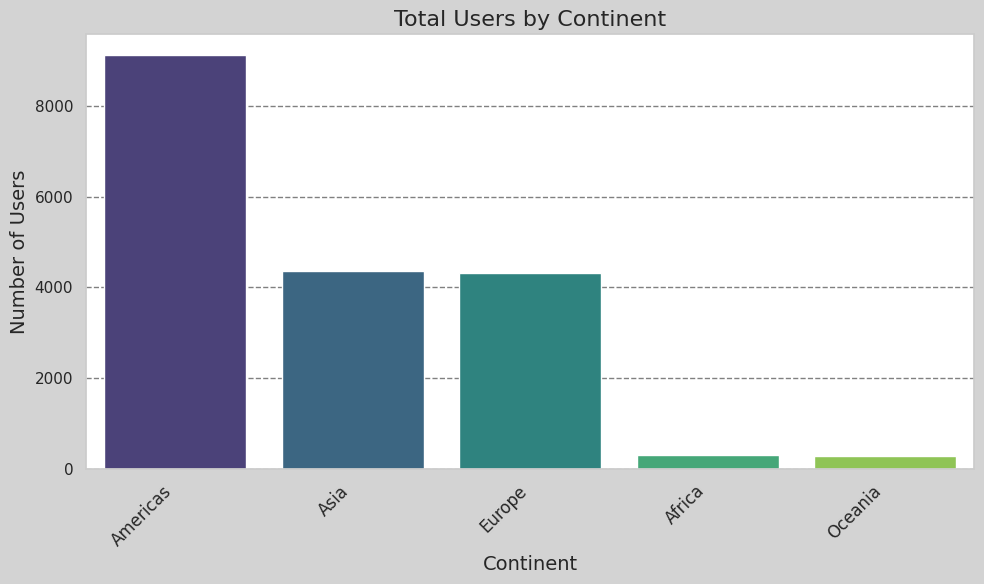

In [ ]:
# Group by continent and count unique users (fullVisitorId)
continent_users = df.groupby('geoNetwork.continent')['fullVisitorId'].nunique().reset_index()
continent_users.columns = ['Continent', 'TotalUsers']

# Sort by TotalUsers in ascending order
continent_users = continent_users.sort_values(by=['TotalUsers'], ascending=False)

# Create the bar plot with customizations
sns.set_theme(style="whitegrid", rc={"grid.color": "gray", "grid.linestyle": "--"})
num_continents = len(continent_users['Continent'])
blue_gradient_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=num_continents)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x='Continent', y='TotalUsers', data=continent_users, palette="viridis")
plt.title('Total Users by Continent', fontsize=16)
plt.xlabel('Continent', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
fig = plt.gcf()
fig.patch.set_facecolor('lightgray')
plt.show()


### 2. Revenue by Continent

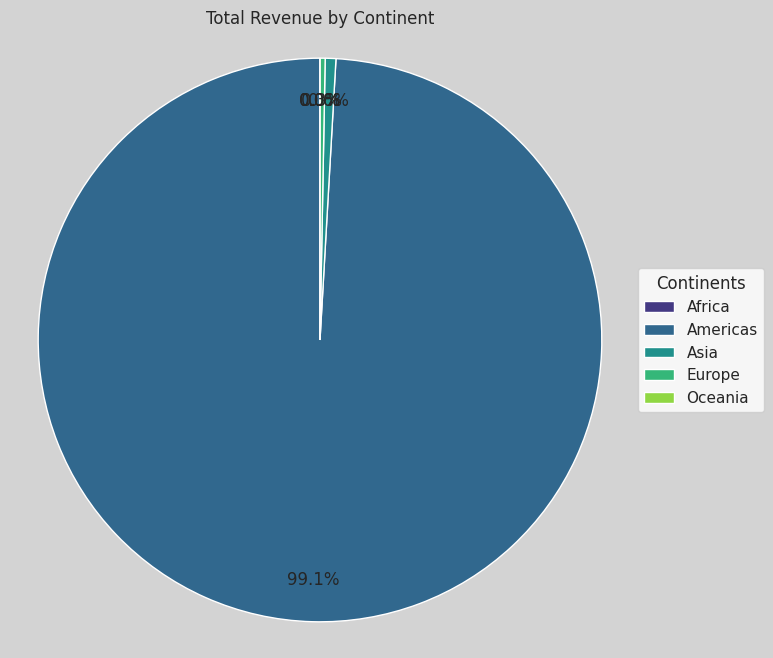

In [ ]:
# Calculate Total Revenue per Continent
revenue_by_continent = df.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum().reset_index()

revenue_by_continent.columns = ['Continent', 'TotalRevenue']

# Create Bar Plot
plt.figure(figsize=(8, 8))
plt.pie(revenue_by_continent['TotalRevenue'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", n_colors=len(revenue_by_continent)),  # Change palette to "viridis"
        pctdistance=0.85)

# Add legend outside the pie chart
plt.legend(revenue_by_continent['Continent'], title="Continents", loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Total Revenue by Continent')
plt.axis('equal')
fig = plt.gcf()
fig.patch.set_facecolor('lightgray')
plt.show()

### 3. Top 10 Countries by Users

<ipython-input-93-c8b36af0d30b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='TotalUsers', data=top_10_countries, palette="viridis")


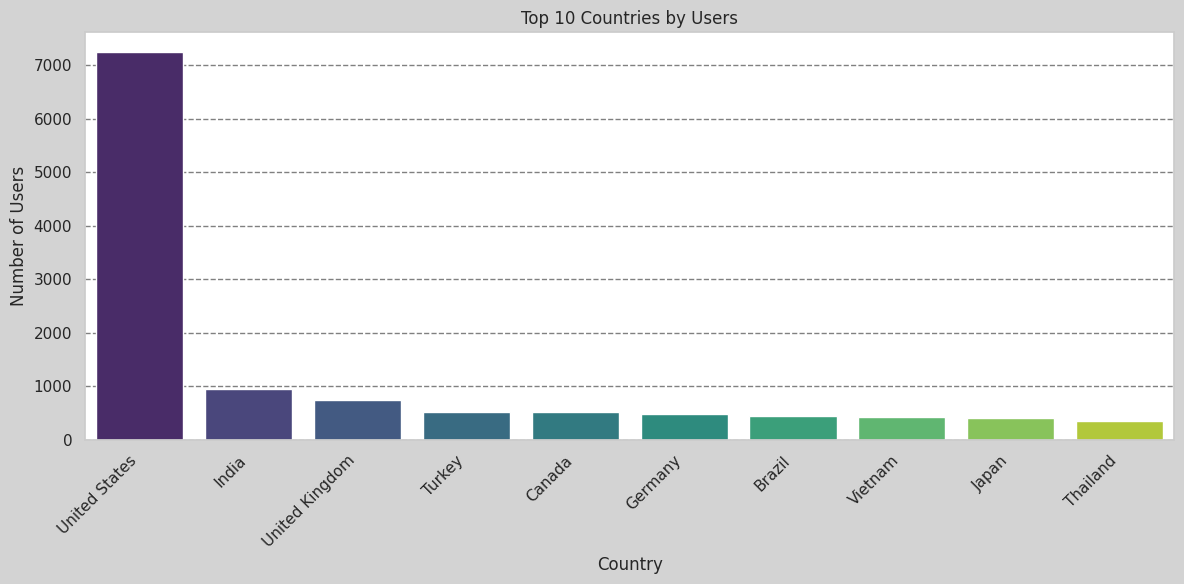

In [ ]:
# 1. Calculate Total Users per Country
country_users = df.groupby('geoNetwork.country')['fullVisitorId'].nunique().reset_index()
country_users.columns = ['Country', 'TotalUsers']

# 2. Get Top 10 Countries
top_10_countries = country_users.sort_values(by=['TotalUsers'], ascending=False).head(10)

# 3. Create Bar Plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
# Reverse the palette before passing it to sns.barplot
palette = sns.color_palette("ch:s=-.2,r=.6")[::-1]
sns.barplot(x='Country', y='TotalUsers', data=top_10_countries, palette="viridis")
plt.title('Top 10 Countries by Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
fig = plt.gcf()
fig.patch.set_facecolor('lightgray')
plt.show()

## **Traffic**

### 1. Total Pageviews by Revenue

Text(0, 0.5, 'Transaction Revenue')

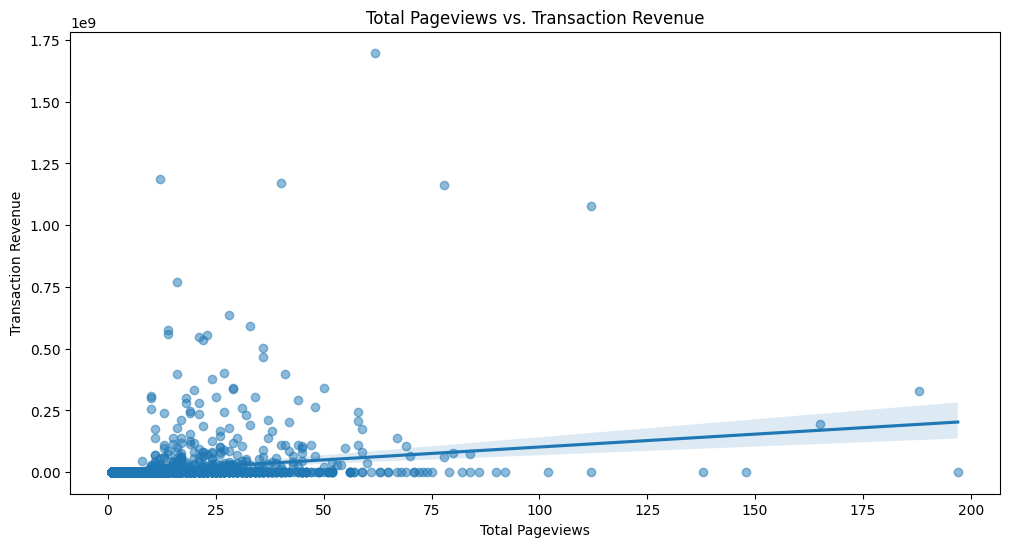

In [ ]:
plt.figure(figsize=(12, 6))
snsregplot = sns.regplot(x='totals.pageviews', y='totals.transactionRevenue', data=df, scatter_kws={'alpha': 0.5})
plt.title('Total Pageviews vs. Transaction Revenue')
plt.xlabel('Total Pageviews')
plt.ylabel('Transaction Revenue')

### 2. Distribution of Bounces

Text(0, 0.5, 'Frequency')

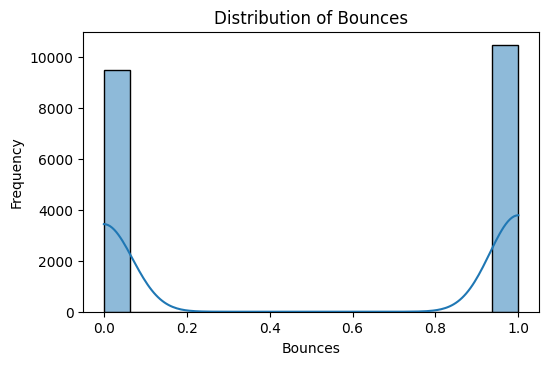

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 1)
sns.histplot(df['totals.bounces'], kde=True)
plt.title('Distribution of Bounces')
plt.xlabel('Bounces')
plt.ylabel('Frequency')

### 3. Total Revenue by Channel

<ipython-input-88-6248737d8e3d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Channel', y='TotalRevenue', data=revenue_by_channel, palette="viridis")


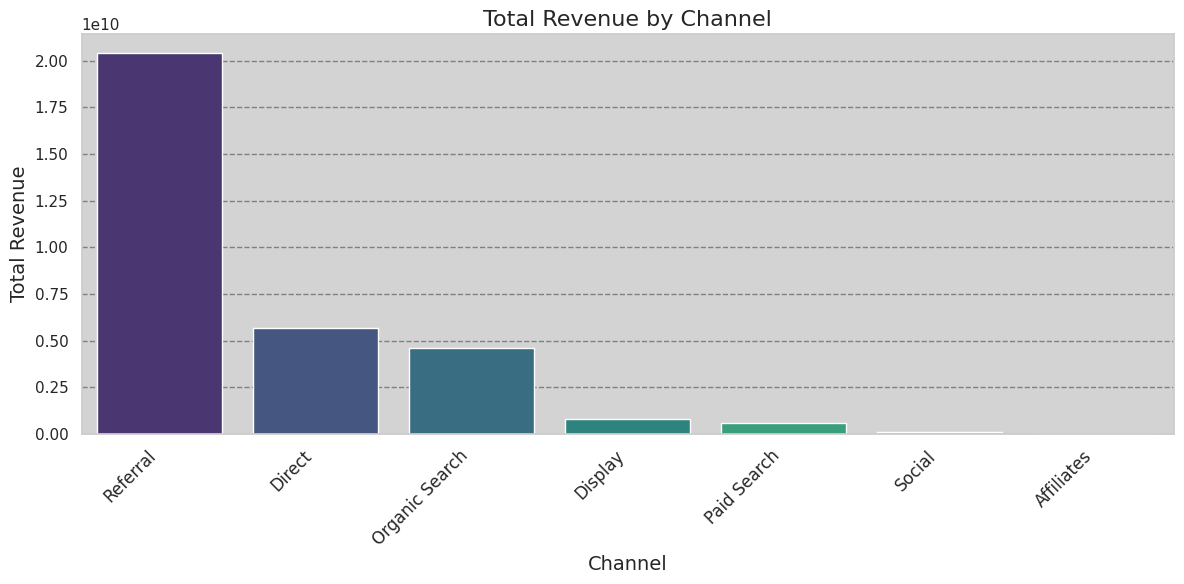

In [ ]:
# Calculate Total Revenue per Channel
revenue_by_channel = df.groupby('channelGrouping')['totals.transactionRevenue'].sum().reset_index()
revenue_by_channel.columns = ['Channel', 'TotalRevenue']

# Sort by TotalRevenue in descending order
revenue_by_channel = revenue_by_channel.sort_values(by=['TotalRevenue'], ascending=False)

# Create Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Channel', y='TotalRevenue', data=revenue_by_channel, palette="viridis")
plt.title('Total Revenue by Channel', fontsize=16)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Set background color to light gray
ax = plt.gca()
ax.set_facecolor('lightgray')

plt.show()

### 4. Distribution of Store Visits by Hour of Day

<ipython-input-113-d8120f68b51e>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(hourly_visits))


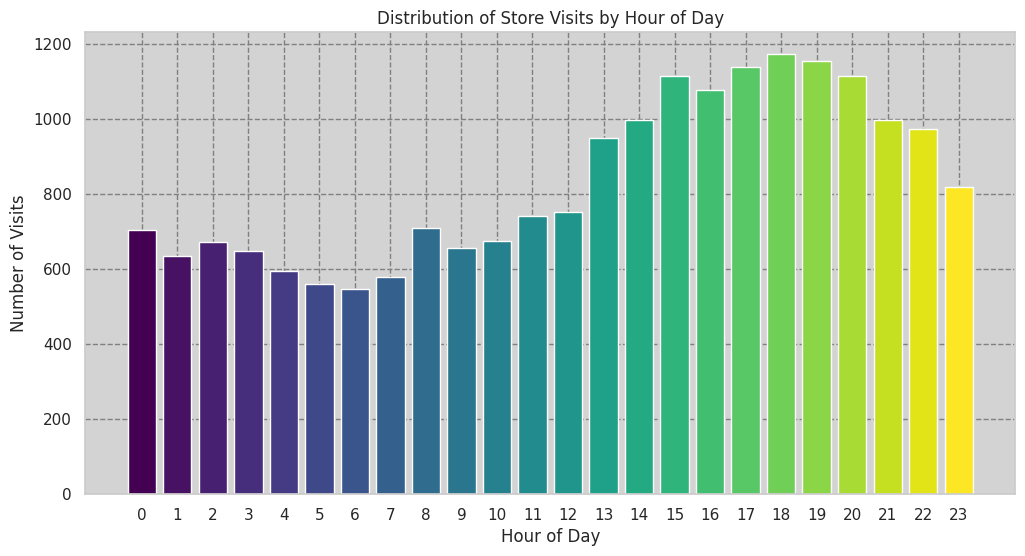

In [ ]:
df['visitHour'] = pd.to_datetime(df['visitStartTime'], unit='s').dt.hour

# Group by visitHour and count the number of visits
hourly_visits = df.groupby('visitHour')['visitStartTime'].count()

# Get the viridis colormap
viridis = cm.get_cmap('viridis', len(hourly_visits))

# Create a bar plot with viridis color coding
plt.figure(figsize=(12, 6))
plt.bar(hourly_visits.index, hourly_visits.values, color=[viridis(i) for i in np.linspace(0, 1, len(hourly_visits))])  # Use viridis colors
plt.xlabel('Hour of Day')
plt.ylabel('Number of Visits')
plt.title('Distribution of Store Visits by Hour of Day')
plt.xticks(range(24))  # Set x-axis ticks to represent each hour
plt.grid(True)

# Remove the custom legend (since we're using viridis)
# ... (Removed legend code) ...

ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

### 5. Distribution of Store Visits by Channel

In [ ]:
import matplotlib.cm as cm

<ipython-input-102-c361e049f236>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(channel_visits))


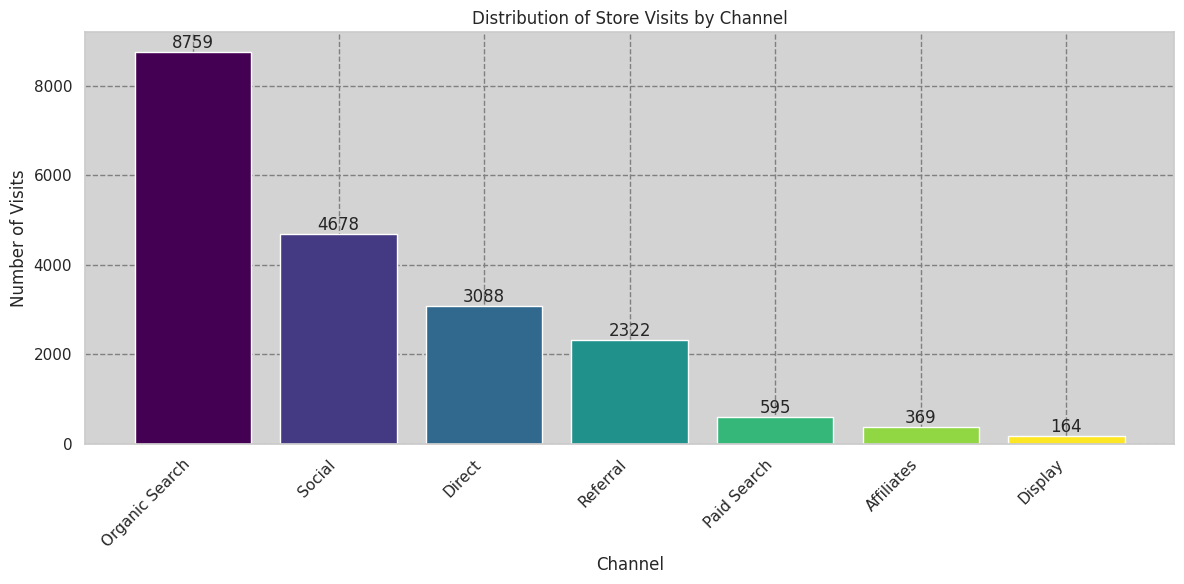

In [ ]:
# Group by channelGrouping and count the number of visits
channel_visits = df.groupby('channelGrouping')['visitStartTime'].count()

# Sort
channel_visits = channel_visits.sort_values(ascending=False)

# Create a bar plot to visualize the distribution
plt.figure(figsize=(12, 6))
viridis = cm.get_cmap('viridis', len(channel_visits))

bars = plt.bar(channel_visits.index, channel_visits.values, color=viridis(range(len(channel_visits))))
plt.xlabel('Channel')
plt.ylabel('Number of Visits')
plt.title('Distribution of Store Visits by Channel')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

### 6. Users by Web Browser

<ipython-input-111-9ae5b3d0b86c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Browser', y='TotalUsers', data=filtered_browsers, palette="viridis")


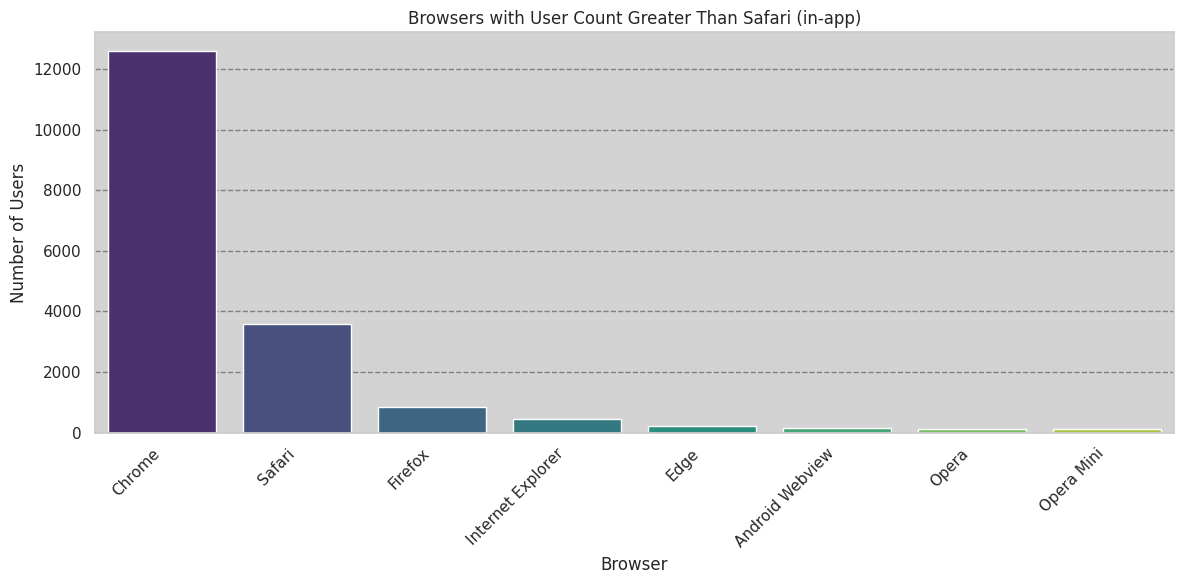

In [ ]:
# Group by browser and count unique users
browser_users = df.groupby('device.browser')['fullVisitorId'].nunique().reset_index()
browser_users.columns = ['Browser', 'TotalUsers']

# Get the user count for Safari (in-app)
safari_in_app_count = browser_users[browser_users['Browser'] == 'Safari (in-app)']['TotalUsers'].values[0]

# Filter browsers with user count greater than Safari (in-app)
filtered_browsers = browser_users[browser_users['TotalUsers'] > safari_in_app_count]
filtered_browsers = filtered_browsers.sort_values(by=['TotalUsers'], ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Browser', y='TotalUsers', data=filtered_browsers, palette="viridis")
plt.title('Browsers with User Count Greater Than Safari (in-app)')
plt.xlabel('Browser')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

## **Devices**

### 1. Visits by Device Category

<ipython-input-104-8920a3fdfb61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=device_visits.index, y=device_visits.values, palette="viridis")


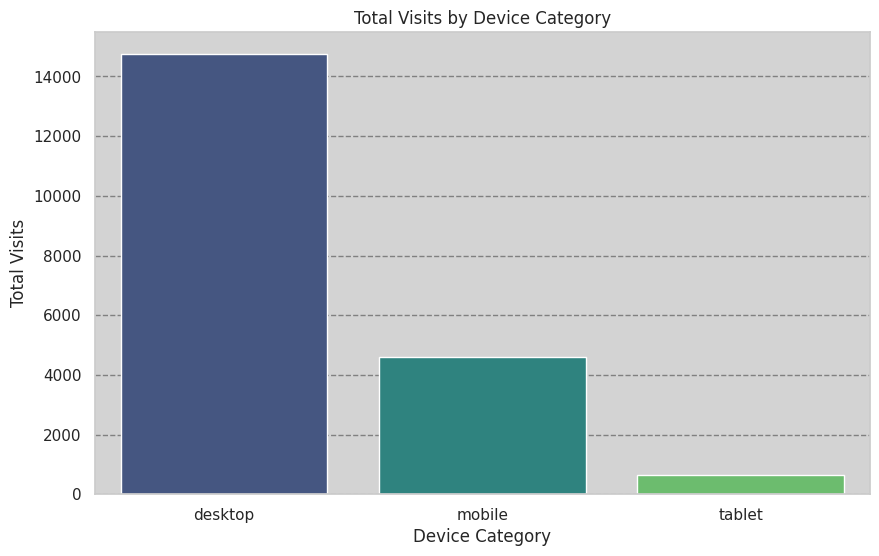

In [ ]:
device_visits = df.groupby('deviceCategory')['visitId'].count()
plt.figure(figsize=(10, 6))
sns.barplot(x=device_visits.index, y=device_visits.values, palette="viridis")
plt.title('Total Visits by Device Category')
plt.xlabel('Device Category')
plt.ylabel('Total Visits')
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

### 2. Number of Returned Users by Device Category

<ipython-input-106-d834b4cf69a8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Device Category', y='Returned Users', data=returned_users_by_device, palette="viridis")


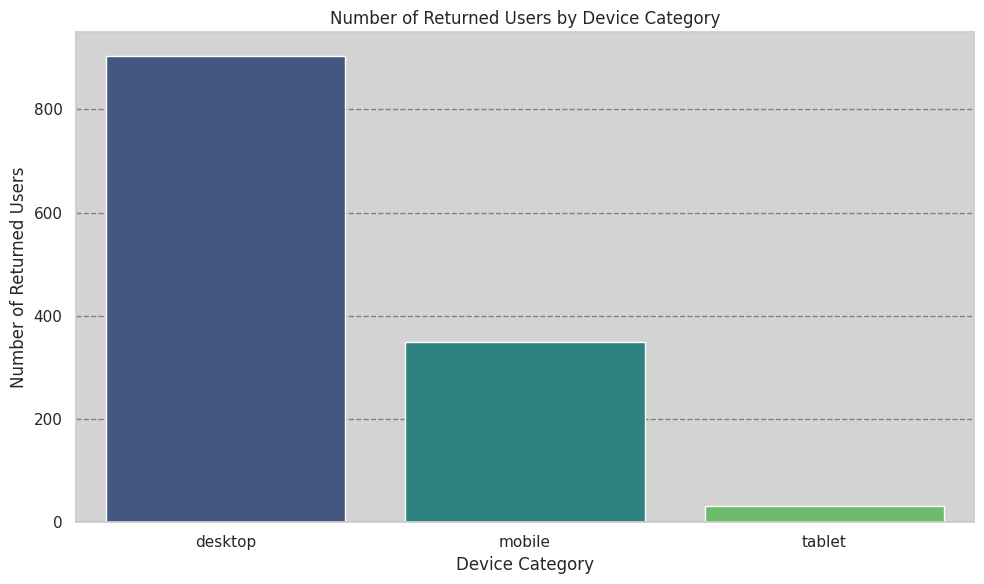

In [ ]:
# Group by device category and user ID, counting visits
device_return_users = df.groupby(['deviceCategory', 'fullVisitorId'])['visitNumber'].count().reset_index()

# Filter for users with more than one visit (returned users)
returned_users = device_return_users[device_return_users['visitNumber'] > 1]

# Group by device category and count unique returned users
returned_users_by_device = returned_users.groupby('deviceCategory')['fullVisitorId'].nunique().reset_index()
returned_users_by_device.columns = ['Device Category', 'Returned Users']

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Device Category', y='Returned Users', data=returned_users_by_device, palette="viridis")
plt.title('Number of Returned Users by Device Category')
plt.xlabel('Device Category')
plt.ylabel('Number of Returned Users')
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

## **Revenue**

### 1. Revenue Progression & Conversion Rate

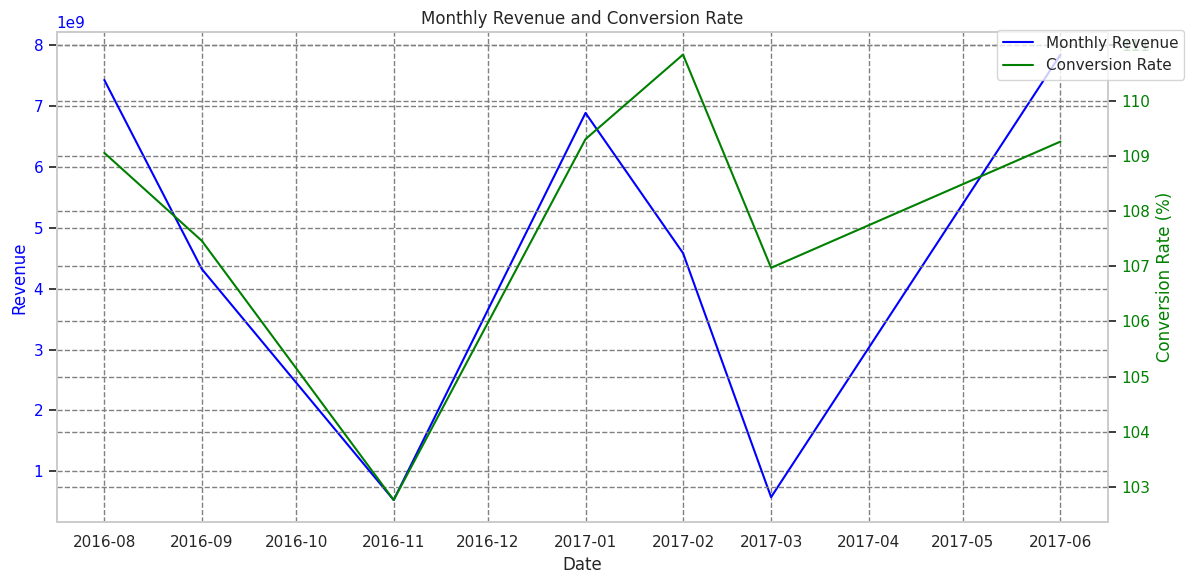

In [ ]:
df['year'] = pd.to_datetime(df['visitStartTime'], unit='s').dt.year
df['month'] = pd.to_datetime(df['visitStartTime'], unit='s').dt.month

df['revenue'] = pd.to_numeric(df['totals.transactionRevenue'], errors='coerce').fillna(0)
# Calculate monthly conversion rate
monthly_visits = df.groupby(['year', 'month'])['fullVisitorId'].nunique().reset_index()  # Unique visitors per month
monthly_transactions = df.groupby(['year', 'month'])['revenue'].count().reset_index() # count transaction per month

# Merge monthly_visits and monthly_transactions on 'year' and 'month'
monthly_data = pd.merge(monthly_visits, monthly_transactions, on=['year', 'month'], how='left')
monthly_data.fillna(0, inplace=True)

monthly_data['conversion_rate'] = (monthly_data['revenue'] / monthly_data['fullVisitorId']) * 100
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(DAY=1))

monthly_revenue = df.groupby(['year', 'month'])['revenue'].sum().reset_index()
monthly_revenue['date'] = pd.to_datetime(monthly_revenue[['year', 'month']].assign(DAY=1))

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot monthly revenue (primary y-axis)
ax1.plot(monthly_revenue['date'], monthly_revenue['revenue'], label='Monthly Revenue', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis for conversion rate
ax2 = ax1.twinx()

# Plot monthly conversion rate (secondary y-axis)
ax2.plot(monthly_data['date'], monthly_data['conversion_rate'], label='Conversion Rate', color='green')
ax2.set_ylabel('Conversion Rate (%)', color='green')
ax2.tick_params('y', labelcolor='green')

# Add title and legend
plt.title('Monthly Revenue and Conversion Rate')
fig.legend(loc='upper right', bbox_to_anchor=(1, 0.95))  # Adjust legend position as needed

plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Revenue Contribution by User Type

<ipython-input-123-1a03a6613fc8>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='userType', y='revenue', data=user_type_revenue, palette='viridis')


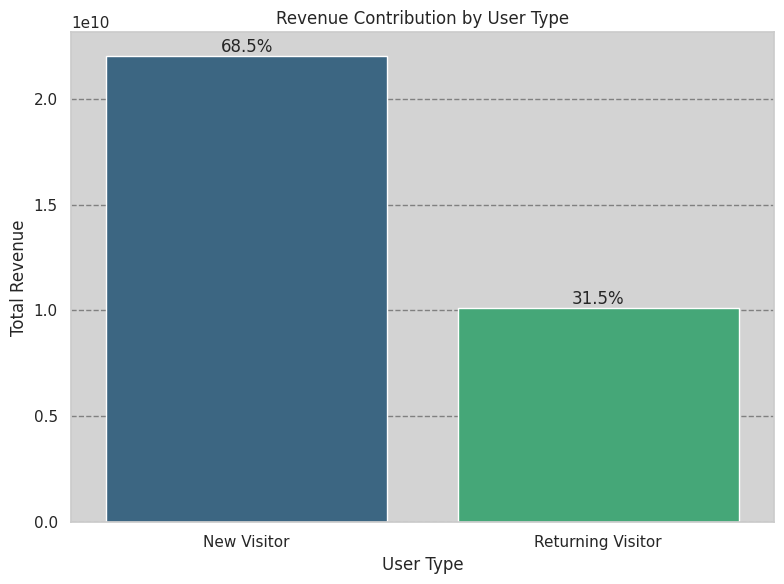

In [ ]:
# Create a new column 'userType' and initialize it to 'New Visitor'
df['userType'] = 'New Visitor'

# Get the first visit time for each visitor
first_visit_times = df.groupby('fullVisitorId')['visitStartTime'].min()

# Update 'userType' for returning visitors
for visitor_id, first_visit_time in first_visit_times.items():
    df.loc[(df['fullVisitorId'] == visitor_id) & (df['visitStartTime'] > first_visit_time), 'userType'] = 'Returning Visitor'

# Group by user type and sum revenue
user_type_revenue = df.groupby('userType')['revenue'].sum().reset_index()

# Calculate percentage contribution
total_revenue = user_type_revenue['revenue'].sum()
user_type_revenue['percentage'] = (user_type_revenue['revenue'] / total_revenue) * 100

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='userType', y='revenue', data=user_type_revenue, palette='viridis')

# Customize the plot
plt.xlabel('User Type')
plt.ylabel('Total Revenue')
plt.title('Revenue Contribution by User Type')
plt.grid(True, axis='y')  # Add vertical grid lines

# Add percentage labels above the bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    percentage = user_type_revenue.loc[i, 'percentage']
    ax.annotate(f'{percentage:.1f}%', (x + width / 2, y + height), ha='center', va='bottom')

plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.show()

## **Model**

## 1. Feature Engineering (II)

In [ ]:
# Total visits
df['total_visits'] = df.groupby('fullVisitorId')['visitId'].transform('count')
# Page views per visit
df['page_views_per_visit'] = df['totals.pageviews'].astype(float) / df['totals.visits'].astype(float)
# Repeat Customer
df['repeat_customer'] = df.groupby('fullVisitorId')['visitId'].transform('nunique') > 1
df['repeat_customer'] = df['repeat_customer'].astype(int)  # Convert to 0/1

In [ ]:
# Device category
device_dummies = pd.get_dummies(df['device.deviceCategory'], prefix='device')
df = pd.concat([df, device_dummies], axis=1)
# Is true direct
df['trafficSource.isTrueDirect'] = df['trafficSource.isTrueDirect'].astype(bool)

In [ ]:
# Hits
df['total_hits'] = df['totals.hits'].astype(float)
# Bounces
df['totals.bounces'] = pd.to_numeric(df['totals.bounces'], errors='coerce').fillna(0)
df['is_bounce'] = (df['totals.bounces'].astype(float) > 0).astype(int)
# New vistis
df['totals.newVisits'] = pd.to_numeric(df['totals.newVisits'], errors='coerce').fillna(0)
df['is_new_visit'] = (df['totals.newVisits'].astype(float) > 0).astype(int)

In [ ]:
# Continent
continent_dummies = pd.get_dummies(df['geoNetwork.continent'], prefix='continent')
df = pd.concat([df, continent_dummies], axis=1)

## 2. Data Splitting

### Defining Target Variables

In [ ]:
X = df[['total_visits', 'page_views_per_visit', 'repeat_customer',
        'device_desktop', 'device_mobile', 'device_tablet',
        'trafficSource.isTrueDirect',
        'total_hits', 'is_bounce', 'is_new_visit',
        'continent_Americas', 'continent_Europe', 'continent_Asia'
       ]]

In [ ]:
# Replace 'No Information' with 0 and then convert to float
df['positive_revenue'] = (pd.to_numeric(df['totals.transactionRevenue'].replace('No Information', 0), errors='coerce') > 0).astype(int)

In [ ]:
y = df['positive_revenue']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Model Selection and Training

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## 5. Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9882352941176471
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3954
           1       0.38      0.22      0.28        41

    accuracy                           0.99      3995
   macro avg       0.68      0.61      0.64      3995
weighted avg       0.99      0.99      0.99      3995



## **Model Visualization**

## 1. Confusion Matrix

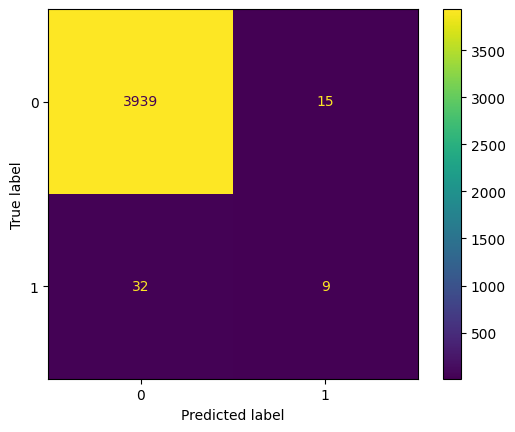

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## X-axis: Predicted class (0: Non-purchasing, 1: Purchasing)
## Y-axis: Actual class (0: Non-purchasing, 1: Purchasing)

## 2. ROC Curve

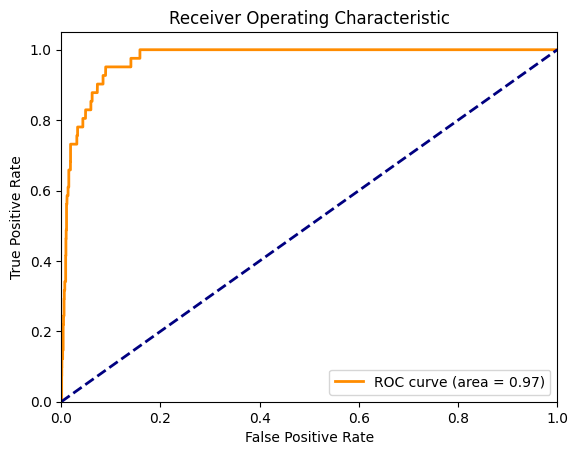

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)  # y_pred_probs are predicted probabilities
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **Insight Interpretation**

In [ ]:
x_variables = ['total_visits', 'page_views_per_visit', 'repeat_customer',
               'device_desktop', 'device_mobile', 'device_tablet',
               'trafficSource.isTrueDirect',
               'total_hits', 'is_bounce', 'is_new_visit',
               'continent_Americas', 'continent_Europe', 'continent_Asia']

correlations = df[['positive_revenue'] + x_variables].corr()
print(correlations['positive_revenue'])

positive_revenue              1.000000
total_visits                  0.050319
page_views_per_visit          0.384192
repeat_customer               0.073172
device_desktop                0.045180
device_mobile                -0.038778
device_tablet                -0.020234
trafficSource.isTrueDirect    0.087000
total_hits                    0.362168
is_bounce                    -0.117677
is_new_visit                 -0.122453
continent_Americas            0.107800
continent_Europe             -0.060010
continent_Asia               -0.060168
Name: positive_revenue, dtype: float64


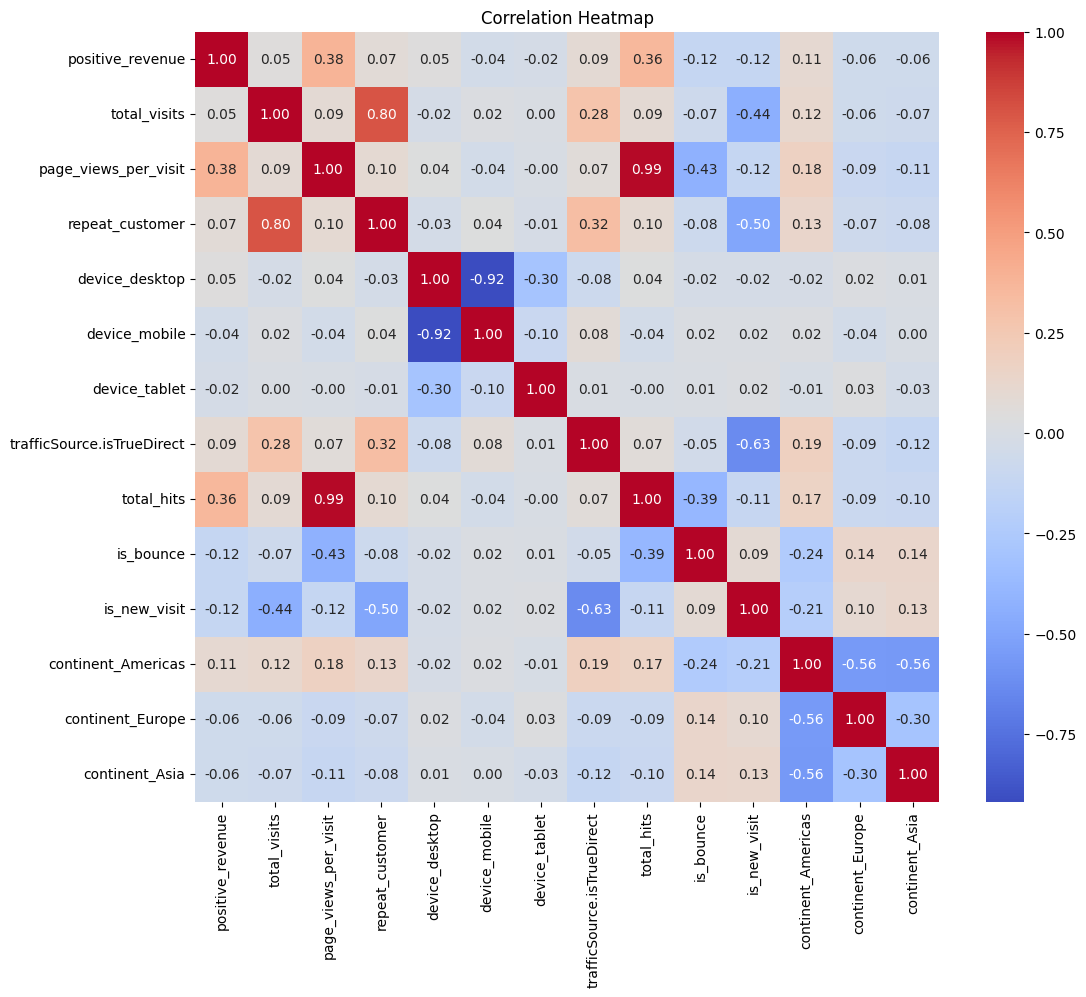

In [ ]:
x_variables = ['total_visits', 'page_views_per_visit', 'repeat_customer',
               'device_desktop', 'device_mobile', 'device_tablet',
               'trafficSource.isTrueDirect',
               'total_hits', 'is_bounce', 'is_new_visit',
               'continent_Americas', 'continent_Europe', 'continent_Asia']

# Calculate correlations
correlations = df[['positive_revenue'] + x_variables].corr()

# Create heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()